In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from jupyterthemes import jtplot
jtplot.style(theme='oceans16', context='notebook', ticks=True, grid=False)

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

<h1>Preparing Data for Model Dev<h1>

In [134]:
df = pd.read_csv("Cleaned_Features.csv")
df['Cars_Category'].replace({'High_Range':'Top_Noch'},inplace=True)

In [135]:
# We need to transform the categorical variables to numbers 
# We will use Dummy Variable
categorical_cols = ['Cars_Category','fueltype','aspiration',
                    'carbody','drivewheel',
                    'enginetype','cylindernumber']
dummies = pd.get_dummies(df[categorical_cols], drop_first= True)
dummies.shape

# it is like a binary matrix for each row, it puts 1 at the variable for that row or 0 otherwise

(205, 22)

In [136]:
# Replacing the variables with the dummies 
df = pd.concat([df, dummies], axis = 1)
df.drop( categorical_cols, axis = 1, inplace = True)
df.drop(columns=['Unnamed: 0'],axis=1,inplace = True)
df.head()

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,carlength,carwidth,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,13495,88.6,2548,130,3.47,111,21,27,168.8,64.1,...,0,0,0,0,0,1,0,0,0,0
1,16500,88.6,2548,130,3.47,111,21,27,168.8,64.1,...,0,0,0,0,0,1,0,0,0,0
2,16500,94.5,2823,152,2.68,154,19,26,171.2,65.5,...,0,0,1,0,0,0,1,0,0,0
3,13950,99.8,2337,109,3.19,102,24,30,176.6,66.2,...,1,0,0,0,0,1,0,0,0,0
4,17450,99.4,2824,136,3.19,115,18,22,176.6,66.4,...,1,0,0,0,1,0,0,0,0,0


### Splitting Data into Test & Train 

In [137]:
# Split
np.random.seed(0)
df_train, df_test = train_test_split(df,
                    train_size = 0.7,
                    test_size = 0.3,
                    random_state = 100)

# 30% for Testing, 70% for Training

### Scaling Numerical Values
We will use standard Scaler
It uses the formula : (X - Mean)/std
where X is the value to be scaled and the mean is the mean of the data
std is the standard deviation
### Scaling is used to have better performance of the model

In [138]:
# The scaling process is used on the numerical variables only
scaler = preprocessing.StandardScaler()
numerical_cols = ['wheelbase','carlength','carwidth','curbweight',
               'enginesize','boreratio','horsepower','citympg','highwaympg','price']

import warnings
warnings.filterwarnings("ignore")
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_train.head()

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,carlength,carwidth,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
122,-0.700200,-0.811836,-0.642128,-0.660242,-1.297329,-0.872898,0.839773,1.025419,-0.487238,-0.924500,...,1,0,0,0,0,1,0,0,0,0
125,1.151931,-0.677177,0.439415,0.637806,2.432256,1.021826,-0.957048,-0.557490,-0.359789,1.114978,...,1,0,0,0,0,1,0,0,0,0
166,-0.452246,-0.677177,-0.441296,-0.660242,-0.259197,0.238673,0.091098,-0.269688,-0.375720,-0.833856,...,0,0,0,0,0,1,0,0,0,0
1,0.442648,-1.670284,0.015642,0.123485,0.625138,0.213410,-0.657578,-0.557490,-0.367754,-0.788535,...,0,0,0,0,0,1,0,0,0,0
199,0.757571,0.972390,1.137720,0.123485,1.201877,1.501822,-1.256518,-1.276993,1.225364,0.616439,...,1,0,0,0,0,1,0,0,0,0


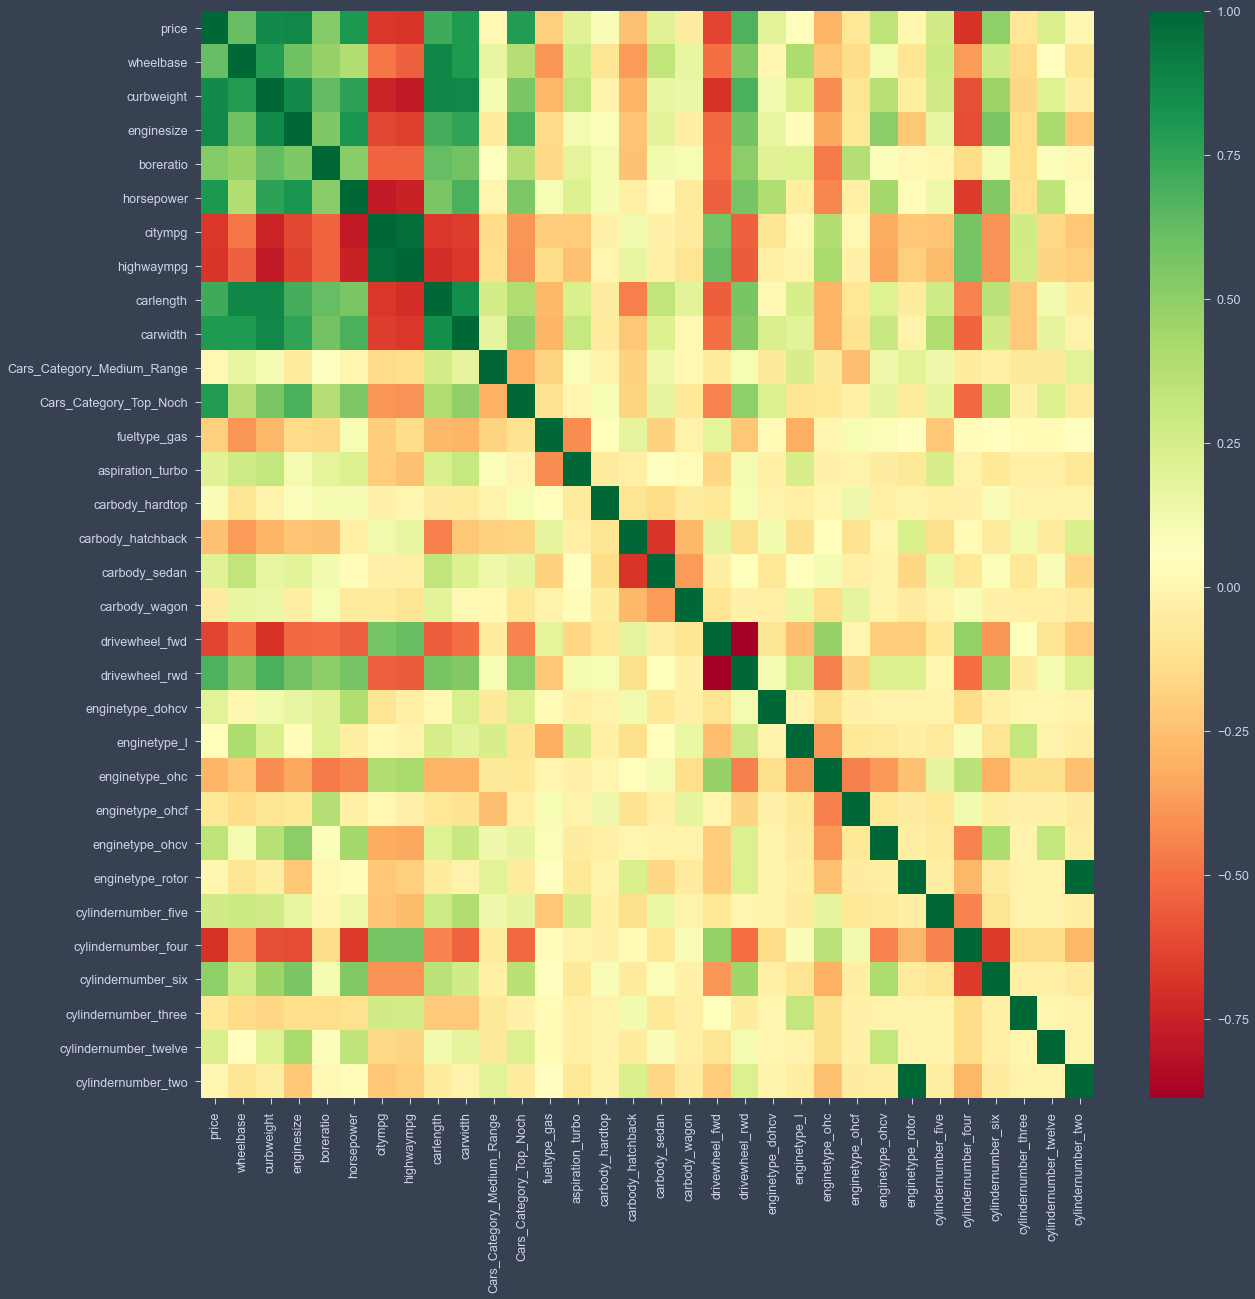

In [139]:
# Checking the correlation to make scatter plots based on the highest correlated variables

plt.figure(figsize = (20, 20))
sns.heatmap(df_train.corr(), cmap="RdYlGn")
plt.show()

# Consider the dark green or dark red as the highly correlated variables with price

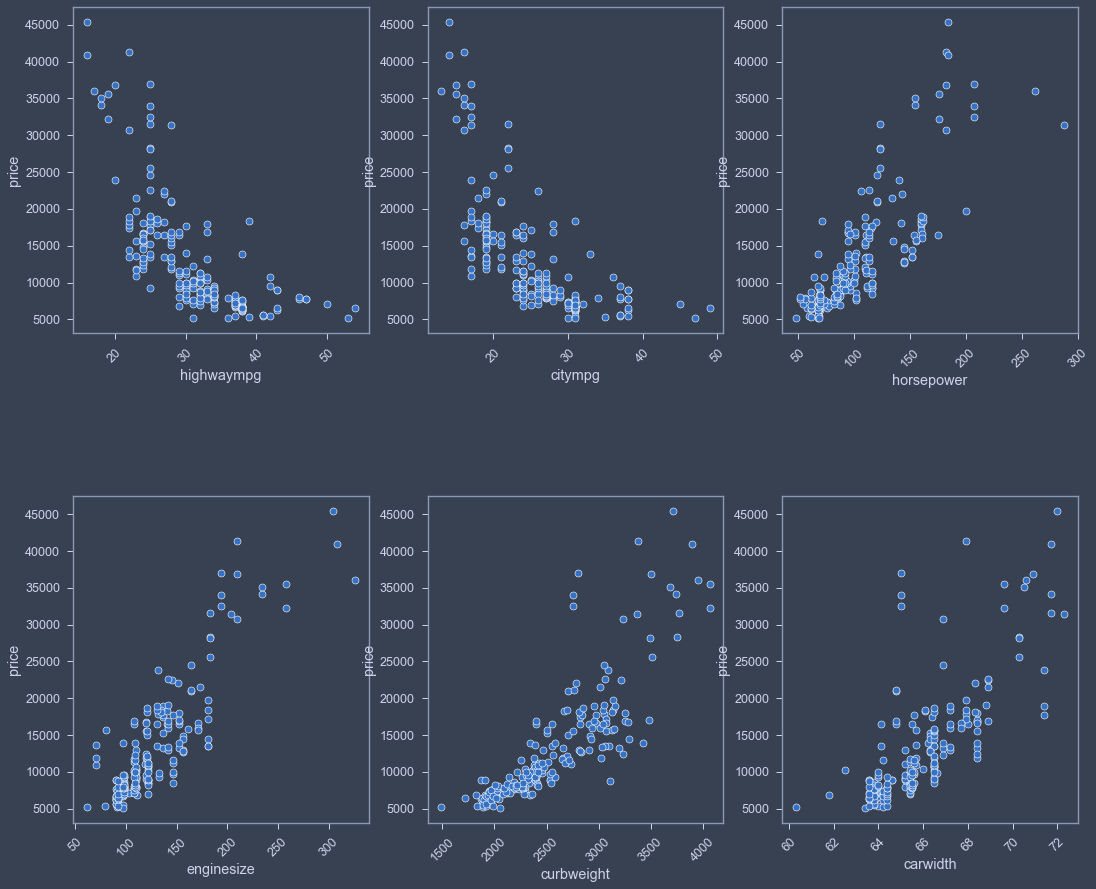

In [140]:
# Now we visualize scatter plots for the highly correlated variables 
# Which are: highwaympg,citympg,horsepower,enginesize,curbweight,carwidth

col = ['highwaympg','citympg','horsepower','enginesize','curbweight','carwidth']

fig,axes = plt.subplots(2,3,figsize=(18,15))
for seg,col in enumerate(col):
    x,y = seg//3,seg%3
    an=sns.scatterplot(x=col, y='price' ,data=df, ax=axes[x,y])
    plt.setp(an.get_xticklabels(), rotation=45)
# Using a loop to visualize scatter plots for ecah column   
plt.subplots_adjust(hspace=0.5)

### Insight
As we can see we have negative and positive correlations <br>
and we can fit a regression line through each one

In [141]:
# Splitting the training set into X for input and Y for prediction

y_train = df_train['price']
X_train = df_train.drop('price',axis=1)
y_train

122   -0.700200
125    1.151931
166   -0.452246
1      0.442648
199    0.757571
         ...   
87    -0.485538
103    0.056900
67     1.606191
24    -0.877585
8      1.390630
Name: price, Length: 143, dtype: float64

<h1> Multiple Regression Model Development <h1>

### Using Recursive Feature Elimination RFE
This algorithm builds a mutiple regression model using the all the attributes <br>
then removing the attributes that are not relevant to finally have a model with <br>
potential significant attributes

In [142]:
# Running RFE Algorithm to build the multiple regression model
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('wheelbase', False, 5),
 ('curbweight', True, 1),
 ('enginesize', False, 11),
 ('boreratio', False, 8),
 ('horsepower', True, 1),
 ('citympg', False, 17),
 ('highwaympg', False, 4),
 ('carlength', False, 12),
 ('carwidth', True, 1),
 ('Cars_Category_Medium_Range', False, 3),
 ('Cars_Category_Top_Noch', True, 1),
 ('fueltype_gas', False, 9),
 ('aspiration_turbo', False, 13),
 ('carbody_hardtop', True, 1),
 ('carbody_hatchback', True, 1),
 ('carbody_sedan', True, 1),
 ('carbody_wagon', True, 1),
 ('drivewheel_fwd', False, 6),
 ('drivewheel_rwd', False, 10),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', False, 15),
 ('enginetype_ohc', True, 1),
 ('enginetype_ohcf', False, 2),
 ('enginetype_ohcv', True, 1),
 ('enginetype_rotor', False, 16),
 ('cylindernumber_five', True, 1),
 ('cylindernumber_four', True, 1),
 ('cylindernumber_six', True, 1),
 ('cylindernumber_three', False, 7),
 ('cylindernumber_twelve', True, 1),
 ('cylindernumber_two', False, 14)]

In [143]:
# What were the attributes selected by the algorithm?
# Called "Supported" columns
col_sup = X_train.columns[rfe.support_]
col_sup

Index(['curbweight', 'horsepower', 'carwidth', 'Cars_Category_Top_Noch',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'enginetype_dohcv', 'enginetype_ohc',
       'enginetype_ohcv', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_twelve'],
      dtype='object')

In [144]:
# Creating X_train dataframe with RFE selected variables

X_train_rfe = X_train[col_sup]

### Develop Using RFE

In [145]:
# Adding a constant variable and Build a first fitted model
import statsmodels.api as sm  
X_train_rfec = sm.add_constant(X_train_rfe)
lm_rfe = sm.OLS(y_train,X_train_rfec).fit()

#Summary of the model performance
print(lm_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     124.2
Date:                Wed, 05 May 2021   Prob (F-statistic):           3.41e-68
Time:                        04:29:22   Log-Likelihood:                -6.1473
No. Observations:                 143   AIC:                             44.29
Df Residuals:                     127   BIC:                             91.70
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Model Enhancement Criteria
1- We look for P-Value and VIF Variance Inflaion Factor to check for dependency among features<br>
2- We drop features with high P-value and High VIF <br>
3- Prioritizing the P-value <br>
We start by dropping the variables with high P-values then we test their VIF <br>
Dropping P-values > 0.05 & VIF > 5

*Dropping `cylindernumber_twelve` beacuse its `p-value` is `0.393` and we want p-value < 0.05 

In [146]:
# Dropping highly correlated variables (cylindernumber_twelve)
X_train_rfe1 = X_train_rfe.drop('cylindernumber_twelve', 1,)

# Adding a constant variable and Build a second fitted model
X_train_rfe1c = sm.add_constant(X_train_rfe1)
lm_rfe1 = sm.OLS(y_train, X_train_rfe1c).fit()

#Summary of lregression model
print(lm_rfe1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     133.3
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.16e-69
Time:                        04:29:22   Log-Likelihood:                -6.5600
No. Observations:                 143   AIC:                             43.12
Df Residuals:                     128   BIC:                             87.56
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

*The next variable with a a high p-value is `cylindernumber_six` with p-value of 0.493, so we dropp it*

In [147]:
# Dropping highly correlated variables cylindernumber_six
X_train_rfe2 = X_train_rfe1.drop('cylindernumber_six', 1,)

# Adding a constant variable and Build a third fitted model
X_train_rfe2c = sm.add_constant(X_train_rfe2)
lm_rfe2 = sm.OLS(y_train, X_train_rfe2c).fit()

#Summary of regression model
print(lm_rfe2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     144.1
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.29e-70
Time:                        04:29:22   Log-Likelihood:                -6.8230
No. Observations:                 143   AIC:                             41.65
Df Residuals:                     129   BIC:                             83.13
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

*Dropping `carbody_hardtop` beacuse its `p-value` is `0.238` and we want p-value less than 0.05 *

In [148]:
# Dropping highly correlated variables carbody_hardtop
X_train_rfe3 = X_train_rfe2.drop('carbody_hardtop', 1,)

# Adding a constant variable and Build a fourth fitted model
X_train_rfe3c = sm.add_constant(X_train_rfe3)
lm_rfe3 = sm.OLS(y_train, X_train_rfe3c).fit()

#Summary of regression model
print(lm_rfe3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     155.5
Date:                Wed, 05 May 2021   Prob (F-statistic):           6.73e-71
Time:                        04:29:22   Log-Likelihood:                -7.5979
No. Observations:                 143   AIC:                             41.20
Df Residuals:                     130   BIC:                             79.71
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

*Dropping `enginetype_ohc` beacuse its `p-value` is `0.110`*

In [149]:
# Dropping highly correlated variables enginetype_ohc
X_train_rfe4 = X_train_rfe3.drop('enginetype_ohc', 1,)

# Adding a constant variable and Build a fifth fitted model
X_train_rfe4c = sm.add_constant(X_train_rfe4)
lm_rfe4 = sm.OLS(y_train, X_train_rfe4c).fit()

#Summary of regression model
print(lm_rfe4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     167.4
Date:                Wed, 05 May 2021   Prob (F-statistic):           1.81e-71
Time:                        04:29:22   Log-Likelihood:                -9.0049
No. Observations:                 143   AIC:                             42.01
Df Residuals:                     131   BIC:                             77.56
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

*Dropping `cylindernumber_five` beacuse its `p-value` is `0.104`*

In [150]:
# Dropping highly correlated variables cylindernumber_five
X_train_rfe5 = X_train_rfe4.drop('cylindernumber_five', 1,)

# Adding a constant variable and Build a sixth fitted model
X_train_rfe5c = sm.add_constant(X_train_rfe5)
lm_rfe5 = sm.OLS(y_train, X_train_rfe5c).fit()

#Summary of regression model
print(lm_rfe5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     181.6
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.91e-72
Time:                        04:29:22   Log-Likelihood:                -10.457
No. Observations:                 143   AIC:                             42.91
Df Residuals:                     132   BIC:                             75.51
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

*Dropping `enginetype_ohcv` beacuse its `p-value` is `0.180`*

In [151]:
# Dropping highly correlated variables enginetype_ohcv
X_train_rfe6 = X_train_rfe5.drop('enginetype_ohcv', 1,)

# Adding a constant variable and Build a sixth fitted model
X_train_rfe6c = sm.add_constant(X_train_rfe6)
lm_rfe6 = sm.OLS(y_train, X_train_rfe6c).fit()

#Summary of regression model
print(lm_rfe6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     200.3
Date:                Wed, 05 May 2021   Prob (F-statistic):           8.26e-73
Time:                        04:29:22   Log-Likelihood:                -11.434
No. Observations:                 143   AIC:                             42.87
Df Residuals:                     133   BIC:                             72.50
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Checking VIF
Now that we have acheived that all variables with `P-Value` < `0.05`. <br>
Variance Inflation Factor, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [152]:
# Create a dataframe that will contain the names of all the feature variables and calculate their VIF's
vif = pd.DataFrame()
vif['Features'] = X_train_rfe6.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe6.values, i) for i in range(X_train_rfe6.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,curbweight,8.10
8,cylindernumber_four,5.66
2,carwidth,5.08
1,horsepower,3.81
5,carbody_sedan,3.35
4,carbody_hatchback,2.47
6,carbody_wagon,1.89
3,Cars_Category_Top_Noch,1.81
7,enginetype_dohcv,1.49


We wanted a `VIF` less than `5`. So, we drop `curbweight` which has `8.1` VIF

In [153]:
# Dropping highly correlated variables curbweight
X_train_rfe7 = X_train_rfe6.drop('curbweight', 1,)

# Adding a constant variable and Build a sixth fitted model
X_train_rfe7c = sm.add_constant(X_train_rfe7)
lm_rfe7 = sm.OLS(y_train, X_train_rfe7c).fit()

#Summary of regression model
print(lm_rfe7.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     203.4
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.86e-71
Time:                        04:29:22   Log-Likelihood:                -18.737
No. Observations:                 143   AIC:                             55.47
Df Residuals:                     134   BIC:                             82.14
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

Now checking `VIF`

In [154]:
#checking VIF for the last model
vif = pd.DataFrame()
vif['Features'] = X_train_rfe7.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe7.values, i) for i in range(X_train_rfe7.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,cylindernumber_four,5.66
4,carbody_sedan,3.35
0,horsepower,2.72
3,carbody_hatchback,2.40
1,carwidth,2.22
2,Cars_Category_Top_Noch,1.73
5,carbody_wagon,1.71
6,enginetype_dohcv,1.24


Dropping `cylindernumber_four` which has VIF of `5.66`

In [155]:
# Dropping highly correlated variables cylindernumber_four
X_train_rfe8 = X_train_rfe7.drop('cylindernumber_four', 1,)

# Adding a constant variable and Build a sixth fitted model
X_train_rfe8c = sm.add_constant(X_train_rfe8)
lm_rfe8 = sm.OLS(y_train, X_train_rfe8c).fit()

#Summary of regression model
print(lm_rfe8.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     215.9
Date:                Wed, 05 May 2021   Prob (F-statistic):           4.70e-70
Time:                        04:29:22   Log-Likelihood:                -24.089
No. Observations:                 143   AIC:                             64.18
Df Residuals:                     135   BIC:                             87.88
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

Checking `VIF`

In [156]:
#checking VIF for the last model
vif = pd.DataFrame()
vif['Features'] = X_train_rfe8.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe8.values, i) for i in range(X_train_rfe8.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,horsepower,2.45
1,carwidth,2.12
2,Cars_Category_Top_Noch,1.70
4,carbody_sedan,1.22
6,enginetype_dohcv,1.22
3,carbody_hatchback,1.10
5,carbody_wagon,1.02


Nowe all the variables have acceptable `P-values` and `VIF`. We can start predictions and accuracy testing.

### Residual Analysis
We need to check the error terms if they are normally distributed in the `training data`

In [157]:
# Predicting the price of training set.
y_train_price = lm_rfe8.predict(X_train_rfe8c)

Text(0.5, 0, 'Errors')

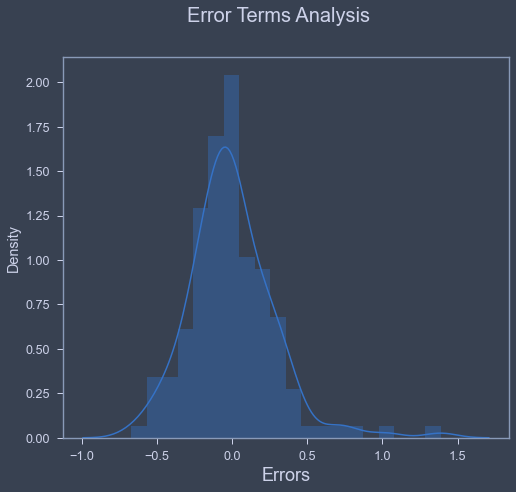

In [158]:
# Plot the histogram of the errors between actual values and predicted values
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms Analysis', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)

### Insight : 
It seems that the error terms are normally ditributed along the training data

## Predictions Using The Enhanced Model 

#### Applying the scaling on the test sets

In [159]:
import warnings
warnings.filterwarnings("ignore")

df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])
df_test.shape

(62, 32)

#### Dividing test set into X_test and y_test

In [160]:
y_test = df_test.pop('price')
X_test = df_test

In [161]:
# Adding constant
#X_test_1 = sm.add_constant(X_test)

#Taking only the columns of the model
#X_test_new = X_test_1[X_train_rfe8c.columns]

# The final predictions should be made by the testing data, all previous predictions were made by training data
#y_pred = lm_rfe8.predict(X_test_new)

In [162]:
# Adding constant
X_test_1 = sm.add_constant(X_test)
X_test_1.head()

,const,wheelbase,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,carlength,carwidth,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
160,1.0,-0.475189,-0.820850,-0.660242,-0.451443,-0.822372,1.887918,2.320526,-0.566894,-0.652569,...,1,0,0,0,0,1,0,0,0,0
186,1.0,-0.205872,-0.487359,-0.390836,-0.451443,-0.443427,0.240833,0.449816,-0.136752,-0.154030,...,1,0,0,0,0,1,0,0,0,0
59,1.0,0.046613,-0.284685,-0.072447,0.317543,-0.468690,0.091098,0.162014,0.349149,0.299187,...,1,0,0,0,0,1,0,0,0,0
165,1.0,-0.677177,-0.505784,-0.660242,-0.259197,0.238673,0.091098,-0.269688,-0.375720,-0.833856,...,0,0,0,0,0,1,0,0,0,0
140,1.0,-0.879165,-0.551846,-0.415328,1.201877,-0.746583,0.091098,0.018113,-1.283797,-0.924500,...,0,1,0,0,0,1,0,0,0,0


In [163]:
#Taking only the columns of the model
X_test_new = X_test_1[X_train_rfe8c.columns]
print(X_train_rfe8c.columns)
print(X_test_new.head())

Index(['const', 'horsepower', 'carwidth', 'Cars_Category_Top_Noch',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon',
       'enginetype_dohcv'],
      dtype='object')
     const  horsepower  carwidth  Cars_Category_Top_Noch  carbody_hatchback  \
160    1.0   -0.822372 -0.652569                       0                  0   
186    1.0   -0.443427 -0.154030                       0                  0   
59     1.0   -0.468690  0.299187                       0                  1   
165    1.0    0.238673 -0.833856                       0                  0   
140    1.0   -0.746583 -0.924500                       0                  1   

     carbody_sedan  carbody_wagon  enginetype_dohcv  
160              1              0                 0  
186              1              0                 0  
59               0              0                 0  
165              1              0                 0  
140              0              0                 0  


In [164]:
# The final predictions should be made by the testing data, all previous predictions were made by training data
y_pred = lm_rfe8.predict(X_test_new)
y_pred.head()

160   -0.642002
186   -0.323572
59    -0.301286
165   -0.326366
140   -0.848163
dtype: float64

## Model Evaluation

Text(0, 0.5, 'y_pred')

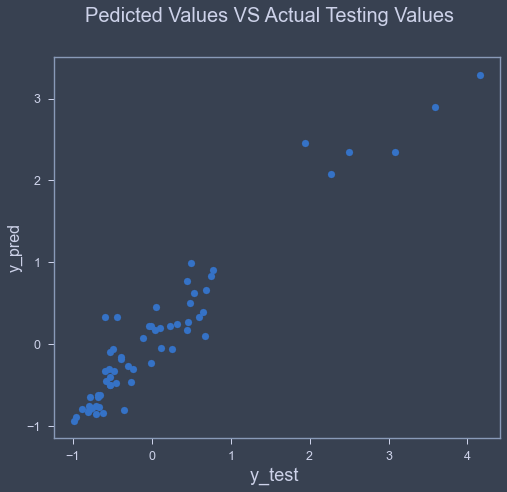

In [165]:
# Plotting y_test and y_pred to compare the difference between actual values and predicted with testing data
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('Pedicted Values VS Actual Testing Values', fontsize=20)   
plt.xlabel('y_test ', fontsize=18)                       
plt.ylabel('y_pred', fontsize=16)    

### RMSE Score

In [166]:
r2_score(y_test, y_pred)

0.9153853722866511

**The R2 score of Training set is 0.918 and Test set is 0.915.
We can say that our model is good enough to predict the Car prices using below predictor variables**
- horsepower
- carwidth	
- Cars_Category_TopNotch_Cars
- carbody_hatchback
- enginetype_dohcv
- carbody_sedan                  
- carbody_wagon                  

In [167]:
# TO get the coefficients of the model
def get_coef_table(lin_reg):
    
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:],
                            'varname': err_series.index.values[1:]
                           })
    return coef_df

get_coef_table(lm_rfe8)

,coef,ci_err,pvalue,varname
0,0.359871,0.077129,0.0000,horsepower
1,0.365185,0.072632,0.0000,carwidth
2,1.289547,0.188095,0.0000,Cars_Category_Top_Noch
3,-0.485907,0.241708,0.0001,carbody_hatchback
4,-0.351776,0.240242,0.0044,carbody_sedan
5,-0.402287,0.267536,0.0035,carbody_wagon
6,-1.444963,0.644409,0.0000,enginetype_dohcv


### Muliple Regression Model Equation :
$Carprice = 0.2440 +  0.3599  \times  horsepower  + 0.3652 
\times  carwidth +  1.2895 \times Carscategorytopnotchcars  - 0.4859 \times carbodyhatchback  - 1.4450 \times enginetypedohcv - 0.3518 \times carbodysedan - 0.4023 \times carbodywagon $

0.244 is the `Constant`

## Final Model Accuracy on Testing Data : 91.53 %

In [168]:
df_train

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,carlength,carwidth,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
122,-0.700200,-0.811836,-0.642128,-0.660242,-1.297329,-0.872898,0.839773,1.025419,-0.487238,-0.924500,...,1,0,0,0,0,1,0,0,0,0
125,1.151931,-0.677177,0.439415,0.637806,2.432256,1.021826,-0.957048,-0.557490,-0.359789,1.114978,...,1,0,0,0,0,1,0,0,0,0
166,-0.452246,-0.677177,-0.441296,-0.660242,-0.259197,0.238673,0.091098,-0.269688,-0.375720,-0.833856,...,0,0,0,0,0,1,0,0,0,0
1,0.442648,-1.670284,0.015642,0.123485,0.625138,0.213410,-0.657578,-0.557490,-0.367754,-0.788535,...,0,0,0,0,0,1,0,0,0,0
199,0.757571,0.972390,1.137720,0.123485,1.201877,1.501822,-1.256518,-1.276993,1.225364,0.616439,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,-0.485538,-0.374195,-0.251520,-0.366345,-0.528342,0.339725,-0.358108,-0.125787,-0.080993,-0.199352,...,1,0,0,0,0,1,0,0,0,0
103,0.056900,0.315930,0.958998,1.372551,0.471340,1.249192,-0.957048,-0.845291,0.890809,0.299187,...,0,0,1,0,0,0,1,0,0,0
67,1.606191,1.931832,1.797333,1.421534,1.048080,0.516566,-0.507843,-0.845291,1.392642,2.021412,...,1,0,0,0,1,0,0,0,0,0
24,-0.877585,-0.811836,-1.054847,-0.856174,-1.297329,-0.872898,0.839773,1.025419,-1.283797,-0.924500,...,1,0,0,0,0,1,0,0,0,0


In [169]:
df =df[['price','horsepower','carwidth','carbody_hatchback','enginetype_dohcv','carbody_wagon','carbody_sedan']]
df

,price,horsepower,carwidth,carbody_hatchback,enginetype_dohcv,carbody_wagon,carbody_sedan
0,13495,111,64.1,0,0,0,0
1,16500,111,64.1,0,0,0,0
2,16500,154,65.5,1,0,0,0
3,13950,102,66.2,0,0,0,1
4,17450,115,66.4,0,0,0,1
...,...,...,...,...,...,...,...
200,16845,114,68.9,0,0,0,1
201,19045,160,68.8,0,0,0,1
202,21485,134,68.9,0,0,0,1
203,22470,106,68.9,0,0,0,1


In [171]:
df.to_csv('Price_Deployment_Data.csv',index=False)